### This notebook is to answer the RQ3: How does technical lag affect external applications?

In [1]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('fast')
from datetime import datetime


sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22

PALETTE_BASE = sns.color_palette('muted', n_colors=12)
blue=PALETTE_BASE[0]
green=PALETTE_BASE[1] 
red=PALETTE_BASE[2] 
purple=PALETTE_BASE[3]
version_colors=['orange',red, 'gray']

In [2]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)

# LOAD DATA

In [3]:
technical_lag=pd.read_csv('../../../jsep2018/csv/repos/all_repos_lag_cleaned.csv', 
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)
print(len(technical_lag))
technical_lag.head(2)

6285154


,dependency,date_used_version,date_last_available,constraint,date,repo,kind,constraint_type,forked,version_lag
0,0,2014-04-01,2014-04-01,0.0.0,2016-03-16,changexbc/vue-app.git,runtime,strict,false,"0,0,0"
1,0,2014-04-01,2014-04-01,0.0.0,2016-09-11,JupiterLikeThePlanet/Recipes.git,development,strict,false,"0,0,0"


In [45]:
technical_lag['year'] = technical_lag['date'].apply(lambda x: x.split('-')[0])

In [49]:
technical_lag.groupby('year').count()[['dependency']]*100/len(technical_lag)

,dependency
year,
2011,0.037458
2012,0.229112
2013,1.516256
2014,7.500266
2015,23.115704
2016,53.119047
2017,13.188641
2018,1.293515


In [4]:
# Considered period
first_date="2010-12-20"
last_date="2018-03-12"
date_period = pd.to_datetime(first_date), pd.to_datetime(last_date)

In [6]:
technical_lag=technical_lag.query('kind!="optional" and kind!="peer"').copy()
technical_lag['kind']=technical_lag['kind'].apply(lambda x: x.capitalize())

In [8]:
len(technical_lag)

6279017

In [77]:
technical_lag.repo.drop_duplicates().size

480497

In [50]:
technical_lag.drop(['date_used_version','date_last_available'],
                   axis=1, inplace=True)

In [78]:
a=technical_lag.groupby('kind').count()
a*100/len(technical_lag)

,dependency,date_used_version,date_last_available,constraint,date,repo,constraint_type,forked,version_lag
kind,,,,,,,,,
Development,53.240786,53.240786,53.240786,53.240786,53.240786,53.240786,53.240786,53.240786,53.240786
Runtime,46.759214,46.759214,46.759214,46.759214,46.759214,46.759214,46.759214,46.759214,46.759214


In [55]:
df_tmp=technical_lag.groupby(['constraint_type','kind']).count()[['constraint']].reset_index()

In [56]:
df_tmp.groupby(['constraint_type']).sum()

,constraint
constraint_type,
caret,4095879
latest,134200
other,210917
strict,1461084
tilde,1138145


In [57]:
df_tmp.groupby(['constraint_type']).sum()

,constraint
constraint_type,
caret,4095879
latest,134200
other,210917
strict,1461084
tilde,1138145


# Technical lag > 0

In [7]:
technical_lag_outdated=technical_lag.query('version_lag!="0,0,0"').query('constraint_type!="latest"')
len(technical_lag_outdated)*100/len(technical_lag)

39.51495910904525

In [8]:
len(technical_lag_outdated)

2481151

In [79]:
df_tmp2=technical_lag_outdated.groupby(['kind']).count()[['constraint']]

In [80]:
df_tmp2*100/len(technical_lag_outdated)

,constraint
kind,
Development,51.809261
Runtime,48.190739


In [83]:
for kind in ['Runtime','Development']:
    df_tmp = technical_lag_outdated.query('kind == "'+kind+'"').copy()
    l=float(len(df_tmp))
    df_tmp=df_tmp.groupby(['constraint_type','kind']).count()[['constraint']].reset_index()
    df_tmp['constraint']=df_tmp['constraint'].apply(lambda x: x*100.0/l)
    print(df_tmp)

  constraint_type     kind  constraint
0           caret  Runtime   25.202792
1           other  Runtime    6.256748
2          strict  Runtime   47.367325
3           tilde  Runtime   21.173135
  constraint_type         kind  constraint
0           caret  Development   53.441476
1           other  Development    1.230449
2          strict  Development   15.990077
3           tilde  Development   29.337999


In [84]:
df_tmp=technical_lag_outdated.groupby(['constraint_type']).count()[['constraint']].reset_index()
l=float(len(technical_lag_outdated))
df_tmp['constraint']=df_tmp['constraint'].apply(lambda x: x*100.0/l)
df_tmp

,constraint_type,constraint
0,caret,39.833045
1,other,3.652660
2,strict,31.111005
3,tilde,25.403291


In [62]:
df_tmp.groupby(['constraint_type']).sum()

,constraint
constraint_type,
caret,32.710503
other,3.569090
strict,41.275053
tilde,22.445355


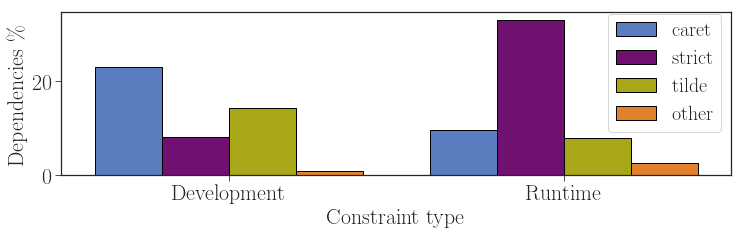

In [13]:
ax = sns.barplot(x="kind", y="constraint", hue="constraint_type", palette=[blue,"purple",'y','#ff7f0e'], data=df_tmp,
                hue_order=['caret','strict','tilde','other'])
ax.figure.set_size_inches(12,3)
ax.set_xlabel('Constraint type')
ax.set_ylabel('Dependencies \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.05), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)
#ax.figure.savefig('../../../../jsep18technicallag/figures/constraints_repos.png', bbox_inches='tight', facecolor='white')

# Aggregate time lag

In [9]:
time_lag=technical_lag_outdated[['repo','kind','date']]

In [10]:
time_lag['time_lag']=(pd.to_datetime(technical_lag_outdated['date_last_available']) 
                      - pd.to_datetime(technical_lag_outdated['date_used_version'])).dt.days

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
time_lag_max=time_lag.groupby(['repo','kind','date']).agg('max').reset_index()

In [14]:
scipy.stats.mannwhitneyu(time_lag_max.query('kind=="Development"').time_lag,time_lag_max.query('kind=="Runtime"').time_lag)

MannwhitneyuResult(statistic=21516552564.0, pvalue=0.0)

In [13]:
cliffsDelta(time_lag_max.query('kind=="Development"').time_lag,time_lag_max.query('kind=="Runtime"').time_lag)

d=0.1068482670312638


False

In [14]:
time_lag_max.query('time_lag!=0').query('kind=="Runtime"').time_lag.median()

218.0

In [94]:
time_lag_max.query('time_lag!=0').query('kind=="Development"').time_lag.median()

275.0

In [17]:
time_lag_max = time_lag_max.query('kind == "Runtime"').copy()

In [21]:
time_lag_max.to_csv('/home/neglectos/Desktop/lab/jsep2018/csv/repos/time_lag_repos.csv', index=False, sep=",")

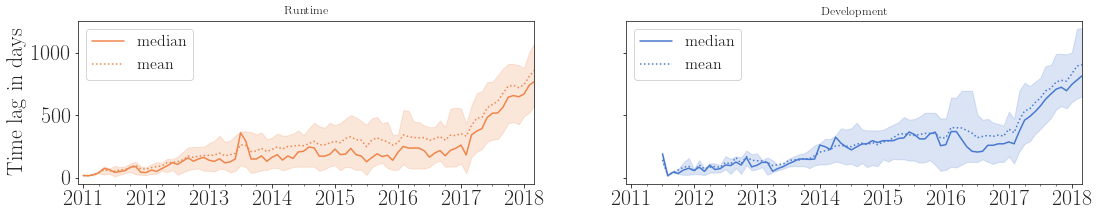

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)
time_lag_max['date']=pd.to_datetime(time_lag_max['date'])
for index, genre in enumerate(['Runtime','Development']):
    size=[12,20,70]
    df_=(time_lag_max.
         query('kind=="{}"'.format(genre)).
         groupby(pd.Grouper(key='date', freq='1M'))['time_lag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )
    genre=genre.capitalize()

    if genre =="Runtime":
        color=green
    else:
        color=blue

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=color)
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=color)
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=color)

    ax.set(
        xlabel='',
        ylabel='Time lag in days'.format(genre),
        title=genre,
        xlim=date_period
    )
    ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})
#fig.savefig('../../../../repositories/jsep18technicallag/figures/time_lag_repos.eps', bbox_inches='tight', facecolor='white')


# Aggregate version lag

In [89]:
version_lag=technical_lag_outdated[['repo','kind','date','version_lag','dependency']]

In [90]:
version_lag=(version_lag.
                 assign(Major=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[0])) ).
                 assign(Minor=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[1]))  ).
                 assign(Patch=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[2])) )
                )
version_lag.drop('version_lag', axis=1, inplace=True)

In [91]:
version_lag_sum=version_lag.groupby(['repo','date','kind']).agg('sum')
version_lag_sum.reset_index(inplace=True)

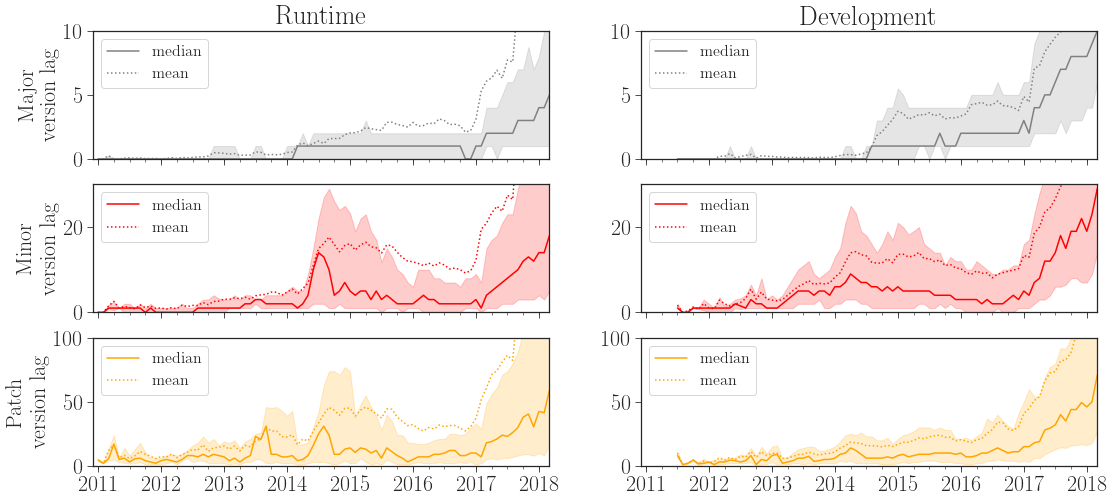

In [98]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=False)
fig.set_size_inches(18,8)
version_lag_sum['date']=pd.to_datetime(version_lag_sum['date'])
for index, genre in enumerate(['Runtime','Development']):
    size=[10,30,100]
    dfs={}
    for x in ['Patch','Minor','Major']:
        dfs[x]=(version_lag_sum.query('kind=="{}"'.format(genre)).
                groupby(pd.Grouper(key='date', freq='1M'))[x].
                describe()[['mean', '25%', '50%', '75%']] 
               )

    colors={}
    colors['Patch']='orange'
    colors['Minor']='r'
    colors['Major']='gray'


    for i, x in enumerate(['Major','Minor','Patch']):
        df_tmp=dfs[x]
        df_tmp['50%'].rename('median').plot(ax=axes[i][index], color=colors[x])
        df_tmp['mean'].plot(style=':',ax=axes[i][index], color=colors[x])
        axes[i][index].fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], color=colors[x], alpha=0.2)

        axes[i][index].set(
            xlabel='',
            ylabel='{} \n version lag'.format(x),
            xlim=date_period,
            ylim=(0,size[i]),
        )
        if i == 0:
            axes[i][index].set(title=genre)
        if index==1:
            axes[i][index].set(ylabel='')

        axes[i][index].legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})

fig.savefig('../../../../repositories/jsep18technicallag/figures/version_lag_repos.pdf', bbox_inches='tight', facecolor='white')

In [100]:
for kind in ['Development','Runtime']:
    dd=version_lag_sum.query('kind=="'+kind+'"')
    print(kind)
    print(dd.Major.median(),dd.Minor.median(),dd.Patch.median())

Development
2.0 4.0 10.0
Runtime
1.0 3.0 9.0


# Constraint Evolution

In [33]:
df_tmp=technical_lag[['constraint_type','kind','date','dependency']]
df_tmp['date']=df_tmp['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
df_tmp=(df_tmp.groupby(['constraint_type','kind','date']).count().
        reset_index().
        merge(df_tmp[['kind','date','dependency']].groupby(['kind','date']).count().reset_index(),
              left_on="date",
              right_on='date',
              how="left")
       )

In [35]:
df_tmp=df_tmp.query('kind_x==kind_y')
df_tmp['dependency']=df_tmp['dependency_x']/df_tmp['dependency_y']
df_tmp.drop(['dependency_x','dependency_y','kind_y'], axis=1, inplace=True)
df_tmp.rename(columns={'kind_x':'kind'}, inplace=True)
df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df_tmp.head()

,constraint_type,kind,date,dependency
0,caret,Development,2014-01-01,0.000235
2,caret,Development,2014-02-01,0.010629
4,caret,Development,2014-03-01,0.075158
6,caret,Development,2014-04-01,0.143105
8,caret,Development,2014-05-01,0.190800


In [36]:
df_tmp['kind']=df_tmp['kind'].apply(lambda x: x.capitalize())
df_tmp_run=(df_tmp.query('kind=="Runtime"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_run['kind']='Runtime'

df_tmp_dev=(df_tmp.query('kind=="Development"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_dev['kind']='Development'
df_tmp_all=pd.concat([df_tmp_run, df_tmp_dev])


In [37]:
for x in df_tmp_all:
    if x=="date" or x=="kind":
        continue
    df_tmp_all[x]=df_tmp_all[x].apply(lambda x: float(x)*100)
df_tmp_all['date']=pd.to_datetime(df_tmp_all['date'])
df_tmp_all['kind']=df_tmp_all['kind'].apply(lambda x: x.capitalize())

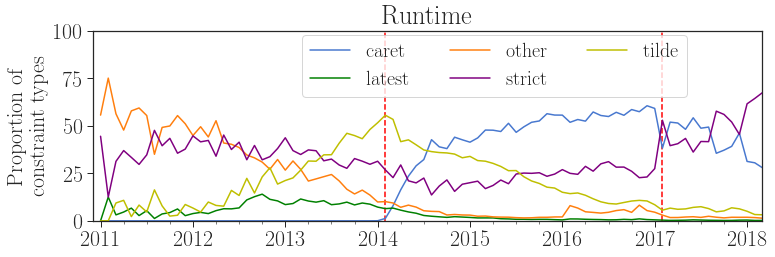

In [43]:
ax=df_tmp_all.query('kind=="Runtime"').plot(x="date",color=[blue,"g",'#ff7f0e','purple','y'],)#, ax=axes[int(i/2)][j], label=type)    

ax.set_ylabel('Proportion of\n constraint types')
ax.set_xlabel('')
ax.figure.set_size_inches(12,3.5)
plt.tick_params(axis='both', which='major', width=1)
ax.set_ylim(0,100)
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(0.6, 0.6))
ax.set_title('Runtime')
ax.set_xlim(date_period)

ax.vlines(pd.to_datetime('2014-02-01'), 0,100, colors='red', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-02-01'), 0,100, colors='red', linestyles='dashed', alpha=1)

ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/constraints_repos_runtime.eps', bbox_inches='tight', facecolor='white')

# Constraints Only for outdated 

In [10]:
df_tmp=technical_lag_outdated[['constraint_type','kind','date','dependency']]
df_tmp['date']=df_tmp['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

df_tmp=(df_tmp.groupby(['constraint_type','kind','date']).count().
        reset_index().
        merge(df_tmp[['kind','date','dependency']].groupby(['kind','date']).count().reset_index(),
              left_on="date",
              right_on='date',
              how="left")
       )

df_tmp=df_tmp.query('kind_x==kind_y')
df_tmp['dependency']=df_tmp['dependency_x']/df_tmp['dependency_y']
df_tmp.drop(['dependency_x','dependency_y','kind_y'], axis=1, inplace=True)
df_tmp.rename(columns={'kind_x':'kind'}, inplace=True)
df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df_tmp.head()

df_tmp['kind']=df_tmp['kind'].apply(lambda x: x.capitalize())
df_tmp_run=(df_tmp.query('kind=="Runtime"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_run['kind']='Runtime'

df_tmp_dev=(df_tmp.query('kind=="Development"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_dev['kind']='Development'
df_tmp_all=pd.concat([df_tmp_run, df_tmp_dev])

for x in df_tmp_all:
    if x=="date" or x=="kind":
        continue
    df_tmp_all[x]=df_tmp_all[x].apply(lambda x: float(x)*100)
df_tmp_all['date']=pd.to_datetime(df_tmp_all['date'])
df_tmp_all['kind']=df_tmp_all['kind'].apply(lambda x: x.capitalize())

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


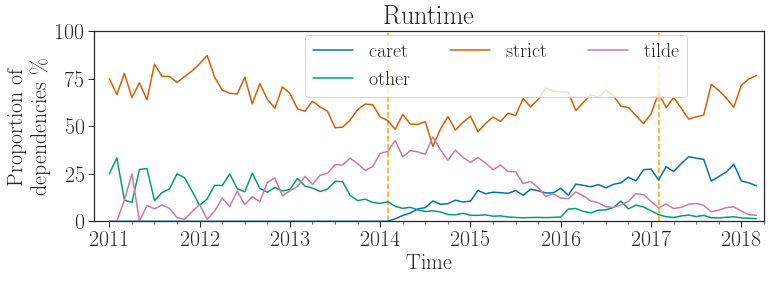

In [12]:
ax=df_tmp_all.query('kind=="Runtime"').plot(x="date",)  

ax.set_ylabel('Proportion of\n dependencies \%')
ax.set_xlabel('Time')
ax.figure.set_size_inches(12,3.5)
plt.tick_params(axis='both', which='major', width=1)
ax.set_ylim(0,100)
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(0.6, 0.6))
ax.set_title('Runtime')
ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))

ax.vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)

#ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/constraints_repos_runtime.eps', bbox_inches='tight', facecolor='white')